### Rank Selection & Cophenetic Correlation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
import os

In [4]:
from scipy.io import loadmat
output = loadmat(os.path.join('..','ssnmf','data','sonar_output.mat'))

In [5]:
init_W = output['params_all']['init_W'][0,0]
init_H = output['params_all']['init_H'][0,0]
max_iter = output['params_all']['max_iter'][0,0]

In [6]:
import ssnmf
model = ssnmf.smoothNMF(r=3, max_iter=1000, betaW=0.1, betaH=0.1, smoothness=5000, sparsity=0.1)
model.fit(output['LL'], init='random')

In [7]:
    # from Nimfa package

    def coph_cor(self, idx=None):
        """
        Compute cophenetic correlation coefficient of consensus matrix, generally obtained from multiple NMF runs. 
        
        The cophenetic correlation coefficient is measure which indicates the dispersion of the consensus matrix and is based 
        on the average of connectivity matrices. It measures the stability of the clusters obtained from NMF. 
        It is computed as the Pearson correlation of two distance matrices: the first is the distance between samples induced by the 
        consensus matrix; the second is the distance between samples induced by the linkage used in the reordering of the consensus 
        matrix [Brunet2004]_.
        
        Return real number. In a perfect consensus matrix, cophenetic correlation equals 1. When the entries in consensus matrix are
        scattered between 0 and 1, the cophenetic correlation is < 1. We observe how this coefficient changes as factorization rank 
        increases. We select the first rank, where the magnitude of the cophenetic correlation coefficient begins to fall [Brunet2004]_.
        
        :param idx: Used in the multiple NMF model. In factorizations following standard NMF model or nonsmooth NMF model
                    :param:`idx` is always None.
        :type idx: None or `str` with values 'coef' or 'coef1' (`int` value of 0 or 1, respectively) 
        """
        A = self.consensus(idx=idx)
        # upper diagonal elements of consensus
        avec = np.array([A[i, j] for i in range(A.shape[0] - 1)
                        for j in range(i + 1, A.shape[1])])
        # consensus entries are similarities, conversion to distances
        Y = 1 - avec
        Z = linkage(Y, method='average')
        # cophenetic correlation coefficient of a hierarchical clustering
        # defined by the linkage matrix Z and matrix Y from which Z was
        # generated
        return cophenet(Z, Y)[0]

In [8]:
from operator import eq
def elop(X, Y, op):
    #try:
    #    X[X == 0] = np.finfo(X.dtype).eps
    #    Y[Y == 0] = np.finfo(Y.dtype).eps
    #except ValueError:
    #    return op(np.mat(X), np.mat(Y))
    return(op(np.mat(X), np.mat(Y)))

In [19]:
    def connectivity(model, X, H=None, idx=None):
        """
        Compute the connectivity matrix for the samples based on their mixture coefficients. 
        
        The connectivity matrix C is a symmetric matrix which shows the shared membership of the samples: entry C_ij is 1 iff sample i and 
        sample j belong to the same cluster, 0 otherwise. Sample assignment is determined by its largest metagene expression value. 
        
        Return connectivity matrix.
        
        :param idx: Used in the multiple NMF model. In factorizations following
            standard NMF model or nonsmooth NMF model ``idx`` is always None.
        :type idx: None or `str` with values 'coef' or 'coef1' (`int` value of 0 or 1, respectively) 
        """
        #X = model.X
        H = model.H
        idx = np.argmax(H, axis=0)
        mat1 = np.tile(idx, (X.shape[1], 1))
        mat2 = np.tile(np.reshape(idx.T,(len(idx),1)), (1, X.shape[1]))
        conn = elop(mat1, mat2, eq)
        #if sp.isspmatrix(conn):
        #    return conn.__class__(conn, dtype='d')
        #else:
        return np.mat(conn, dtype='d')

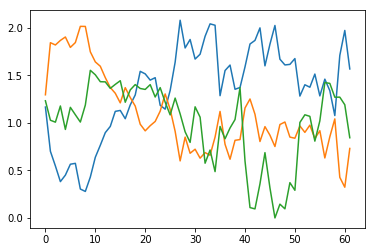

In [10]:
res = connectivity(model, output['LL'])

In [18]:
def consensus(n_runs, X, model, parallel=False):
    """
    Compute consensus matrix as the mean connectivity matrix across multiple runs of the factorization. It has been
    proposed by [Brunet2004]_ to help visualize and measure the stability of the clusters obtained by NMF.
        
    Tracking of matrix factors across multiple runs must be enabled for computing consensus matrix. For results
    of a single NMF run, the consensus matrix reduces to the connectivity matrix.
        
    :param idx: Used in the multiple NMF model. In factorizations following
            standard NMF model or nonsmooth NMF model ``idx`` is always None.
    :type idx: None or `str` with values 'coef' or 'coef1' (`int` value of 0 or 1, respectively) 
    """
        #V = self.target(idx)
        #if self.track_factor:
        #    if sp.isspmatrix(V):
        #        cons = V.__class__((V.shape[1], V.shape[1]), dtype=V.dtype)
        #    else:
        #        cons = np.mat(np.zeros((V.shape[1], V.shape[1])))
        #    for i in range(self.n_run):
        #        cons += self.connectivity(
        #            H=self.tracker.get_factor(i).H, idx=idx)
        #    return sop(cons, self.n_run, div)
        #else:
        #    return self.connectivity(H=self.coef(idx), idx=idx)
    
    def get_con(it):
        model.fit(X, init='random')
        return(connectivity(model,X))
        
    
    if not parallel:
        cons = np.mat(np.zeros((X.shape[1], X.shape[1])))

        for run in range(n_runs):
            model.fit(X, init='random')
            cons += connectivity(model, X)
    else:
        #from multiprocessing import Pool
        #res = Pool(4).map(get_con, range(n_runs))

        
        from concurrent.futures import ThreadPoolExecutor
        ex = ThreadPoolExecutor()
        res = ex.map(get_con, range(n_runs))
        cons = np.sum(np.array(list(res)),axis=0)
        
    
    return(cons/n_runs)

In [28]:
X = output['LL']
# normalize the pixel values over time

# normalize by norm
# X = (output['LL'].T/np.linalg.norm(output['LL'],axis=1)).T

# normalize by std
X = (output['LL'].T/np.std(output['LL'],axis=1)).T

In [14]:
import math

In [30]:
# %%time
# p = Pool(4)
# res = p.map(math.cos, range(1000000))

In [31]:
# %%time
#res = list(map(math.cos,range(1000000)))

In [20]:
%%time
cons_matrix = consensus(40, X, model, parallel=True)

CPU times: user 34min 42s, sys: 10min 16s, total: 44min 58s
Wall time: 7min 36s


In [21]:
%%time
cons_matrix = consensus(40, X, model, parallel=False)

CPU times: user 24min 22s, sys: 5min 34s, total: 29min 56s
Wall time: 7min 58s


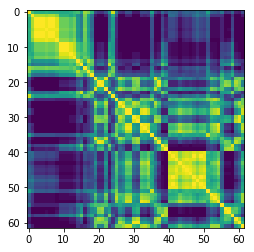

In [22]:
plt.imshow(cons_matrix)

(62, 62)

In [33]:
def coph_cor(X, model, n_runs = 1, parallel=False):
        """
        Compute cophenetic correlation coefficient of consensus matrix, generally obtained from multiple NMF runs. 
        
        The cophenetic correlation coefficient is measure which indicates the dispersion of the consensus matrix and is based 
        on the average of connectivity matrices. It measures the stability of the clusters obtained from NMF. 
        It is computed as the Pearson correlation of two distance matrices: the first is the distance between samples induced by the 
        consensus matrix; the second is the distance between samples induced by the linkage used in the reordering of the consensus 
        matrix [Brunet2004]_.
        
        Return real number. In a perfect consensus matrix, cophenetic correlation equals 1. When the entries in consensus matrix are
        scattered between 0 and 1, the cophenetic correlation is < 1. We observe how this coefficient changes as factorization rank 
        increases. We select the first rank, where the magnitude of the cophenetic correlation coefficient begins to fall [Brunet2004]_.
        
        :param idx: Used in the multiple NMF model. In factorizations following standard NMF model or nonsmooth NMF model
                    :param:`idx` is always None.
        :type idx: None or `str` with values 'coef' or 'coef1' (`int` value of 0 or 1, respectively) 
        """
        A = consensus(n_runs, X, model, parallel = parallel)
        # upper diagonal elements of consensus
        avec = np.array([A[i, j] for i in range(A.shape[0] - 1)
                        for j in range(i + 1, A.shape[1])])
        # consensus entries are similarities, conversion to distances
        Y = 1 - avec
        Z = linkage(Y, method='average')
        # cophenetic correlation coefficient of a hierarchical clustering
        # defined by the linkage matrix Z and matrix Y from which Z was
        # generated
        return (cophenet(Z, Y)[0], cophenet(Z,Y)[1])

In [34]:
from scipy.cluster.hierarchy import linkage, cophenet

In [35]:
%%time
c, D = coph_cor(X, model, n_runs=40, parallel=True)

CPU times: user 35min 9s, sys: 10min 13s, total: 45min 23s
Wall time: 7min 51s


In [37]:
from scipy.spatial.distance import squareform

Text(0.5, 1.0, 'Cophenetic Correlation is 0.86')

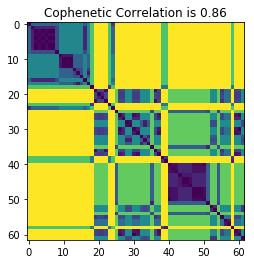

In [38]:
plt.imshow(squareform(D))
plt.title('Cophenetic Correlation is {}'.format(round(c,2)))

In [39]:
def estimate_rank(ranks, X, model, n_runs=10, parallel=False):
    # run for different ranks
    c_dict = {}
    D_dict = {}
    for r in ranks:
        model.rank = r
        c, D = coph_cor(X=X, model=model, n_runs=n_runs, parallel=parallel)
        c_dict[r] = c
        D_dict[r] = D
    rank = max(c_dict.keys(), key=(lambda k: c_dict[k]))   
    return(rank, c_dict, D_dict)
    

In [40]:
rank, c_dict, D_dict = estimate_rank(ranks=range(2,6), X=X, model=model, n_runs=10, parallel=True)

In [ ]:
# run for different ranks
c_dict = {}
D_dict = {}
for r in range(2,6):
    model.rank = r
    c, D = coph_cor(output['LL'], model, n_runs = 10)
    c_dict[r] = c
    D_dict[r] = D
    
    
rank = max(c_dict.keys(), key=(lambda k: c_dict[k]))  
print(rank)

Text(0.5, 0, 'Rank')

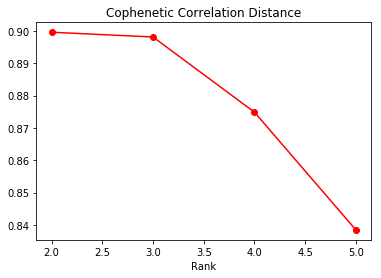

In [42]:
# plot the Cophenetic Correlation wrt to Rank
plt.plot(np.array(list(c_dict.keys())),c_dict.values(),'ro-')
plt.title("Cophenetic Correlation Distance")
plt.xlabel("Rank")

In [ ]:
# Notes:
# for 1000 iterations I get a warning and returns nans
# most probably division by zero (not clear which run)
# the connectivity is the same for each observation: i.e. all observations are assigned to the same component
# so the variance becomes zero and that results in dividing by zero
# It works when smoothness and sparsity are lower and there is more variation in the coefficients and they intersect each other.

In [36]:
# normalize X (matlab version)
# output['LL']

# LL_norm = nan(size(LL));
# sigma_all = nan(size(LL,1),1);
# for irow = 1:size(LL,1)
#    sigma = std(LL(irow,:));
#    LL_norm(irow,:) = LL(irow,:)/sigma;
#    sigma_all(irow) = sigma;
# end
# LL = LL_norm;  % use normalized data for decomposition

In [ ]:
%%time
c, D = coph_cor(LL_norm, model, n_runs = 10)

In [ ]:
c_dict

In [ ]:
plt.imshow(squareform(D_dict[5]))

Extra Stuff

In [ ]:
rho = np.corrcoef(model.H.T,model.H.T)

In [ ]:
# matlab version 
function seq = find_match_factor_seq(rho,rank)
% Find matching component sequence based on correlation coefficients
%
% Inputs
%   rho   correlation coefficients (based on H or W, H seems to give better results)
%   rank  rank of the decomposition
%
% Outputs
%   seq   matching sequence
%
% Wu-Jung Lee | leewujung@gmail.com
% 2019 05 03

icomp = 1;
while icomp<=rank
    if icomp==1
        seq = nan(rank,1);
    end
    [~,max_ind] = max(rho(:));
    [x_ind,y_ind] = ind2sub(size(rho),max_ind);
    seq(x_ind) = y_ind;

    
    icomp = icomp+1;
end

In [ ]:
def find_match_factor_seq(rho, n_components):
    """
    Find matching component sequence based on correlation coefficients

    Inputs
       rho   correlation coefficients (based on H or W, H seems to give better results)
       rank  rank of the decomposition

    Outputs
       seq   matching sequence
    """
    seq = {}
    for c in range(n_components):
        ind = np.argmax(rho)
        row_ind, col_ind = np.unravel_index(ind, rho.shape)
        seq[row_ind] = col_ind
        rho[row_ind,:] = -2
        rho[:,col_ind] = -2
        
    return (seq)
        
    

In [ ]:
seq = find_match_factor_seq(rho, 3)